In [ ]:
# This notebook contains the code for the experiments in Section 5.3 and 5.4

In [1]:
%run Correlators_tools.ipynb

### Model characteristics

In [2]:
m = 0 # number of polynomials -1 (i.e. the total number is m+1)

r = 0.02
t = 0
T = 2
time_sequence = np.linspace(t, T, m+2)[1:]
initial_state = 2.0

# I choose the parameters so that mean = initial_state and std = np.sqrt(T)
b1 = 0.01
b0 = -initial_state*b1
ts = np.append(t, time_sequence)
var_sum = 0
for j in range(m+1):
    for k1 in range(j, m+1):
        for k2 in range(j, m+1):
            var_sum += (np.exp(b1*(ts[k1+1]+ts[k2+1]-2*ts[j]))-np.exp(b1*(ts[k1+1]+ts[k2+1]-2*ts[j+1])))
sigma0 = 2*b1*(m+1)**2/var_sum
polyp_coeff_vector = np.array([b0, b1, sigma0, 0, 0])

# Lévy parameters (NIG)
a = 1.0
b = 0
mu = 0
delta = 1/(T-t)/10
polyp_coeff_vector_levy = np.array([a, b, mu, delta]) 

Y = poly_process_sparse_levy(polyp_coeff_vector, polyp_coeff_vector_levy)

print('b1, b0, sigma0 = ', b1, ',', b0,',', sigma0)
print('a, b, mu, delta ', a, ',', b,',', mu, ',', delta)

b1, b0, sigma0 =  0.01 , -0.02 , 0.49006666488895684
a, b, mu, delta  1.0 , 0 , 0 , 0.05


In [3]:
order = 1
mean = (e_n_i(order+1,order+1).transpose()).dot(Y.exp_generator_matrix_scipy(order, t=T)).dot(H_n_x(order, initial_state))
mean = mean[0,0]
order = 2
std = (e_n_i(order+1,order+1).transpose()).dot(Y.exp_generator_matrix_scipy(order, t=T)).dot(H_n_x(order, initial_state))
std = np.sqrt(std[0,0]-mean**2)
            

print('mean = ', mean)
print('std = ', std)

mean =  2.0000000000000004
std =  1.0025474286905582


## PRICING

In [5]:
# Preliminary calculations for the Hermite series
# This does not depend on the strike price

N = 50 # truncation number
expG_N = lambda t: Y.exp_generator_matrix_scipy(n = N*(m+1), t=t)
#E_matrix = mE_n_matrix(N, m)
#D_matrix = mD_n_matrix(N, m)

In [6]:
H_N = np.zeros(N+1) 
H_N[0] = 1
for n in range(1,N+1):
    print('----------------- n = ', n)
    H_N_n = 0
    index_list = multi_index(m, n)
    for i in index_list:
        coeff = multi_coeff(i)
        max_power = np.max(i)
        non_zero_count = np.count_nonzero(i)
        non_zero_position = np.nonzero(i)
        #vectors_list = coeff_vectors_list(i[non_zero_position], max_power)
        #expG_n = lambda t: csr(expG_N(t).toarray()[:(max_power*non_zero_count+1), :(max_power*non_zero_count+1)])
        #correlator = Y.correlator_formula_2(expG_n, max_power, non_zero_count-1, time_sequence[non_zero_position], vectors_list, initial_state)
        #correlator = Y.correlator_formula_3(expG_n, E_matrix[max_power-1][:non_zero_count], D_matrix[max_power-1][:non_zero_count], max_power, non_zero_count-1, time_sequence[non_zero_position], vectors_list, initial_state)
        #correlator = (e_n_i(max_power+1,max_power+1).transpose()).dot(Y.exp_generator_matrix_scipy(max_power, t=T)).dot(H_n_x(max_power, initial_state))
        vectors_list = coeff_vectors_list2(i[non_zero_position])
        correlator = Y.recursive_moment_formula(non_zero_count-1, i[non_zero_position], time_sequence[non_zero_position], vectors_list, t).dot(H_n_x(np.sum(i[non_zero_position]), initial_state))   
        H_N_n += coeff*correlator[0,0]
    
    H_N[n] = H_N_n/float(((m+1)**n))   
    
print('H_N = ', H_N)

----------------- n =  1
----------------- n =  2
----------------- n =  3
----------------- n =  4
----------------- n =  5
----------------- n =  6
----------------- n =  7
----------------- n =  8
----------------- n =  9
----------------- n =  10
----------------- n =  11
----------------- n =  12
----------------- n =  13
----------------- n =  14
----------------- n =  15
----------------- n =  16
----------------- n =  17
----------------- n =  18
----------------- n =  19
----------------- n =  20
----------------- n =  21
----------------- n =  22
----------------- n =  23
----------------- n =  24
----------------- n =  25
----------------- n =  26
----------------- n =  27
----------------- n =  28
----------------- n =  29
----------------- n =  30
----------------- n =  31
----------------- n =  32
----------------- n =  33
----------------- n =  34
----------------- n =  35
----------------- n =  36
----------------- n =  37
----------------- n =  38
----------------- n =

In [7]:
# Strike price
K = 2.0

In [8]:
# MONTE CARLO SIMULATIONS

N_mc = 100 # number of samples
IT = 20000 # number of iterations for each sample

price_MC = np.zeros(N_mc)
time_MC = np.zeros(N_mc)
for mc in range(N_mc):
    print(mc)
    exp = np.zeros(IT)
    at = time.time()
    for it in range(IT):
        Delta = (T-t)/(m+1)
        Z = np.zeros(m+2)
        Z[0] = initial_state
        for k in np.arange(m+1):
            Z[k+1] = Z[k]*np.exp(b1*Delta)+b0/b1*(np.exp(b1*Delta)-1) + np.random.normal(loc = 0, scale =  np.sqrt(sigma0*(np.exp(2*b1*Delta)-1)/2/b1))
            Z[k+1] += nig.rvs(a=a, b=b, loc = mu, scale = delta*Delta, size = 1)
        Z = Z[1:]
        exp[it] = max(np.sum(Z)/(m+1)-K,0)*np.exp(-r*(T-t))
    price_MC[mc] = np.sum(exp)/IT
    bt = time.time()
    time_MC[mc] = bt-at

print('MC_price_interval = [', np.mean(price_MC) - np.std(price_MC), ', ', np.mean(price_MC) + np.std(price_MC), ']')
print('std = ', np.std(price_MC))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
MC_price_interval = [ 0.38116649848374634 ,  0.38920606816990083 ]
std =  0.004019784843077271


### Pricing with generalized Hermite polynomials

In [9]:
# Parameters for the Hermite series 
min_scale = std/np.sqrt(2) #\underline{b}_{\sigma}
print('min_scale = ', min_scale)

drift = mean
scale = min_scale*1.2
ratio = (K-drift)/scale

print('K = ', K)
print('drift = ', drift)
print('scale = ', scale)
print('ratio = ', ratio)

min_scale =  0.7089080852882303
K =  2.0
drift =  2.0000000000000004
scale =  0.8506897023458764
ratio =  -5.220343077216459e-16


In [10]:
# We now calculate the moments of X (see Eq. (4.4))

E_N = np.zeros(N+1) 
E_N[0] = 1
for j in range(1, N+1):
    E_N_j = 0
    for i in range(j+1):
        E_N_j += float(newton(j,i))*H_N[i]*((-drift)**(j-i))
    E_N[j] = E_N_j/(scale**(j))
    
print('E_N = ', E_N)

E_N =  [ 1.00000000e+00  0.00000000e+00  1.38888889e+00  1.44273541e-14
  5.78718613e+00  4.46572892e-13  4.01908726e+01  1.12839703e-11
  3.90775063e+02 -5.92520227e-10  4.88519841e+03 -1.37897758e-08
  7.46447622e+04 -1.99699114e-06  1.34796567e+06 -1.73913051e-04
  2.80878199e+07 -2.76163018e-02  6.63325666e+08 -2.57491780e+01
  1.75086345e+10 -7.90046208e+03  5.10805589e+11 -1.74989162e+06
  1.63222658e+13 -5.71387724e+08  5.66937429e+14 -1.23631894e+11
  2.12687898e+16 -1.52300383e+13  8.57070543e+17 -1.15171375e+15
  3.69174652e+19  8.09924821e+15  1.69134945e+21  2.40915884e+19
  8.19445603e+22  4.67631231e+21  4.18036735e+24  5.05137527e+23
  2.24989291e+26  3.33606370e+25  1.28411698e+28  1.37471081e+27
  2.95898781e+33 -2.20074790e+35  5.83417322e+36  3.51893887e+37
 -8.58222416e+39  3.85800469e+41 -1.16942973e+43]


k =  1 , price =  0.32606896294979004
k =  2 , price =  0.3894712613011382
k =  3 , price =  0.3894712613011382
k =  4 , price =  0.38330512332094996
k =  5 , price =  0.38330512332094996
k =  6 , price =  0.3845048948416063
k =  7 , price =  0.3845048948416063
k =  8 , price =  0.38421298715509095
k =  9 , price =  0.38421298715509095
k =  10 , price =  0.38429256038441995
k =  11 , price =  0.38429256038441995
k =  12 , price =  0.3842693109116833
------> Accuracy 10**(-3) for k =  10
k =  13 , price =  0.3842693109116833
k =  14 , price =  0.38427643008074513
k =  15 , price =  0.38427643008074513
k =  16 , price =  0.38427417492645516
k =  17 , price =  0.38427417492645516
k =  18 , price =  0.38427490800281877
k =  19 , price =  0.38427490800281877
k =  20 , price =  0.3842746633451377
k =  21 , price =  0.3842746633451377
k =  22 , price =  0.3842747482790923
k =  23 , price =  0.3842747482790923
k =  24 , price =  0.38427461215937875
k =  25 , price =  0.38427461215937875
k =  2

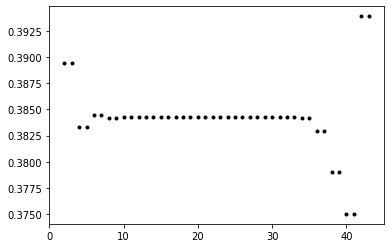

In [11]:
# We now calculate the option price via Hermite series Eq. (4.5)
# We calculate the accuracy accordingly to Eq. (5.9) 

Hprice = np.ones(N+1)*(scale*norm.pdf(ratio)+(mean-K)*(1-norm.cdf(ratio)))*np.exp(-r*(T-t))
notachieved = 1
best_n = -10
best = 0
print('k = ', 1, ', price = ', Hprice[0])
for k in range(2,N+1):
    v_k = hermite(k).c[::-1]
    Hprice[(k-1):] += scale*norm.pdf(ratio)*(hermite(k-2)(ratio)/float(math.factorial(k))*v_k.dot(E_N[:(k+1)]))*np.exp(-r*(T-t))
    print('k = ', k, ', price = ', Hprice[k-1])
    if (np.abs(Hprice[k-1]) < 5): plt.plot(k, Hprice[k-1], 'k.')
    if (k>3):
        if (-np.log10(abs((Hprice[k-3]-Hprice[k-1])/Hprice[k-3]))>4) and notachieved:
            notachieved = 0
            best = Hprice[k-3]
            best_n = k-2
            print('------> Accuracy 10**(-3) for k = ', k-2)

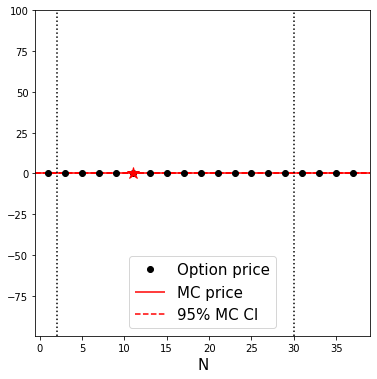

In [13]:
# Plots

f = plt.figure(figsize = (6,6))
mmin = 0
mmax = 38
mmin2 = 2
mmax2 = 30

plt.plot(np.arange(mmin+1, mmax+1, 2), Hprice[mmin:(mmax):2], 'ok')
plt.hlines(y = np.mean(price_MC), xmin=mmin-0.5, xmax = mmax+1, colors ='red', linestyles='solid')
plt.hlines(y = np.mean(price_MC)+1.96*np.std(price_MC)/np.sqrt(N_mc), xmin=mmin-0.5, xmax = mmax+1, colors ='red', linestyles='dashed')
plt.hlines(y = np.mean(price_MC)-1.96*np.std(price_MC)/np.sqrt(N_mc), xmin=mmin-0.5, xmax = mmax+1, colors ='red', linestyles='dashed')
plt.xlim([mmin-0.5,mmax+1]);
plt.ylim([np.mean(price_MC)-100, np.mean(price_MC)+100])
plt.xlabel('N', fontsize=15)
plt.xticks(np.arange(mmin, mmax+1, 5), np.arange(mmin, mmax+1, 5), fontsize=10);
plt.legend(['Option price','MC price', '95% MC CI'], fontsize=15);
plt.axvline(x = mmin2, color='k', linestyle=':')
plt.axvline(x = mmax2, color='k', linestyle=':')
plt.plot(best_n+1, best, 'r*', markersize=12);
#f.savefig('Plots_JD_corr/plot_JD_corr_20_12.pdf', bbox_inches = 'tight', pad_inches = 0.01)


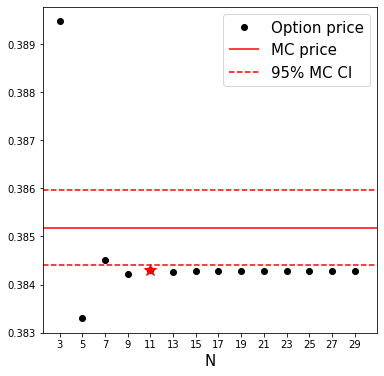

In [14]:
f = plt.figure(figsize = (6,6))
plt.plot(np.arange(mmin2+1, mmax2+1, 2), Hprice[mmin2:(mmax2):2], 'ok')
plt.hlines(y = np.mean(price_MC), xmin=mmin2-0.5, xmax = mmax2+1, colors ='red', linestyles='solid')
plt.hlines(y = np.mean(price_MC)+1.96*np.std(price_MC)/np.sqrt(N_mc), xmin=mmin2-0.5, xmax = mmax2+1, colors ='red', linestyles='dashed')
plt.hlines(y = np.mean(price_MC)-1.96*np.std(price_MC)/np.sqrt(N_mc), xmin=mmin2-0.5, xmax = mmax2+1, colors ='red', linestyles='dashed')
plt.xlim([mmin2-0.5,mmax2+1]);
plt.xlabel('N', fontsize=15)
plt.xticks(np.arange(mmin2+1, mmax2+1, 2), np.arange(mmin2+1, mmax2+1, 2), fontsize=10);
plt.legend(['Option price', 'MC price', '95% MC CI'], fontsize=15);
plt.plot(best_n+1, best, 'r*', markersize=12, zorder=4);
#f.savefig('Plots_JD_corr/plot_JD_corr_20_1_zoom2.pdf', bbox_inches = 'tight', pad_inches = 0.01)
